# <center>**Capstone Project**</center>
##### <center>(Computer Vision)</center>

---


## Project
**Pneumonia Detection Challenge**

## Objective
* In this capstone project, our goal is to build a pneumonia detection system, to locate the position of inflammation in an image.
* Tissues with sparse material, such as lungs which are full of air, do not absorb the X-rays and appear black in the image. Dense tissues such as bones absorb X-rays and appear white in the image.
* While we are theoretically detecting “lung opacities”, there are lung opacities that are not pneumonia related.

## Dataset
We are using the `RSNA Pneumonia Detection Challenge` dataset from [kaggle](https://https://www.kaggle.com/) <br>
Link of the dataset : https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/data

* In the data, some of these are labeled “Not Normal No Lung Opacity”. This extra third class indicates that while pneumonia was determined not to be present, there was nonetheless some type of abnormality on the image and oftentimes this finding may mimic the appearance of true pneumonia.
* Dicom original images: - Medical images are stored in a special format called DICOM files (*.dcm). They contain a combination of header metadata as well as underlying raw image arrays for pixel data.

We are using 2 csv file from the dataset
 - stage_2_detailed_class_info.csv renamed into `detailed_class_info.csv`
 - stage_2_train_lebels.csv renamed into `train_lebels.csv`

Also we have the set of training images under folder named stage_2_train_images

## Group:
Group CV-2

## Analysis By:


*   PRITAM CHOWDHARY
*   SAMEER GUPTA

*   ARUNN KUMARAN G P

*   SURAJKUMAR PATIL

*   SOUMALYA BISWAS









---
===================================================================================================================


---



In [ ]:
import os
import csv
import random
import pydicom
import numpy as np
import pandas as pd
import seaborn as sns
from skimage import io
from skimage import measure
from skimage.transform import resize

import tensorflow as tf
from tensorflow import keras

from matplotlib import pyplot as plt
import matplotlib.patches as patches

# Load pneumonia locations

Table contains [filename : pneumonia location] pairs per row. 
* If a filename contains multiple pneumonia, the table contains multiple rows with the same filename but different pneumonia locations. 
* If a filename contains no pneumonia it contains a single row with an empty pneumonia location.

The code below loads the table and transforms it into a dictionary. 
* The dictionary uses the filename as key and a list of pneumonia locations in that filename as value. 
* If a filename is not present in the dictionary it means that it contains no pneumonia.

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
# empty dictionary
pneumonia_locations = {}
# load table
with open(os.path.join('/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv'), mode='r') as infile:
    # open reader
    reader = csv.reader(infile)
    # skip header
    next(reader, None)
    # loop through rows
    for rows in reader:
        # retrieve information
        filename = rows[0]
        location = rows[1:5]
        pneumonia = rows[5]
        # if row contains pneumonia add label to dictionary
        # which contains a list of pneumonia locations per filename
        if pneumonia == '1':
            # convert string to float to int
            location = [int(float(i)) for i in location]
            # save pneumonia location in dictionary
            if filename in pneumonia_locations:
                pneumonia_locations[filename].append(location)
            else:
                pneumonia_locations[filename] = [location]

# Load filenames

In [ ]:
# load and shuffle filenames
folder = '../input/rsna-pneumonia-detection-challenge/stage_2_train_images'
filenames = os.listdir(folder)
random.shuffle(filenames)
# split into train and validation filenames
n_valid_samples = 2560
train_filenames = filenames[n_valid_samples:]
valid_filenames = filenames[:n_valid_samples]
print('n train samples', len(train_filenames))
print('n valid samples', len(valid_filenames))
n_train_samples = len(filenames) - n_valid_samples

n train samples 24124
n valid samples 2560


# Exploration

Total train images: 26684
Images with pneumonia: 6012


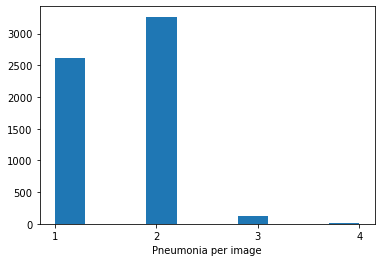

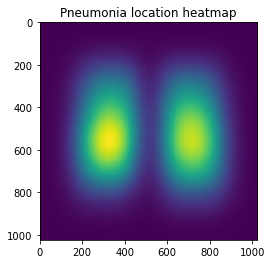

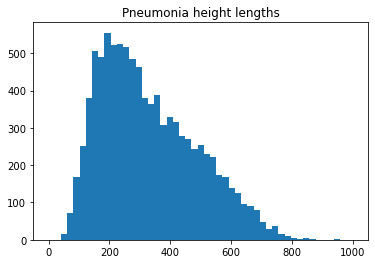

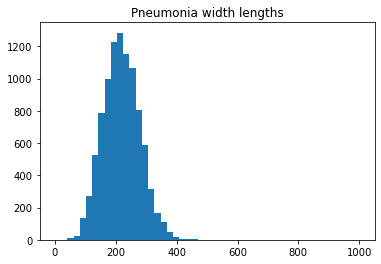

Minimum pneumonia height: 45
Minimum pneumonia width:  40


In [ ]:
print('Total train images:',len(filenames))
print('Images with pneumonia:', len(pneumonia_locations))

ns = [len(value) for value in pneumonia_locations.values()]
plt.figure()
plt.hist(ns)
plt.xlabel('Pneumonia per image')
plt.xticks(range(1, np.max(ns)+1))
plt.show()

heatmap = np.zeros((1024, 1024))
ws = []
hs = []
for values in pneumonia_locations.values():
    for value in values:
        x, y, w, h = value
        heatmap[y:y+h, x:x+w] += 1
        ws.append(w)
        hs.append(h)
plt.figure()
plt.title('Pneumonia location heatmap')
plt.imshow(heatmap)
plt.figure()
plt.title('Pneumonia height lengths')
plt.hist(hs, bins=np.linspace(0,1000,50))
plt.show()
plt.figure()
plt.title('Pneumonia width lengths')
plt.hist(ws, bins=np.linspace(0,1000,50))
plt.show()
print('Minimum pneumonia height:', np.min(hs))
print('Minimum pneumonia width: ', np.min(ws))


 # Data generator

The dataset is too large to fit into memory, so we need to create a generator that loads data on the fly.

* The generator takes in some filenames, batch_size and other parameters.

* The generator outputs a random batch of numpy images and numpy masks.
    

In [ ]:
class generator(keras.utils.Sequence):
    
    def __init__(self, folder, filenames, pneumonia_locations=None, batch_size=32, image_size=256, shuffle=True, augment=False, predict=False):
        self.folder = folder
        self.filenames = filenames
        self.pneumonia_locations = pneumonia_locations
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.augment = augment
        self.predict = predict
        self.on_epoch_end()
        
    def __load__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # create empty mask
        msk = np.zeros(img.shape)
        # get filename without extension
        filename = filename.split('.')[0]
        # if image contains pneumonia
        if filename in self.pneumonia_locations:
            # loop through pneumonia
            for location in self.pneumonia_locations[filename]:
                # add 1's at the location of the pneumonia
                x, y, w, h = location
                msk[y:y+h, x:x+w] = 1
        # resize both image and mask
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        msk = resize(msk, (self.image_size, self.image_size), mode='reflect') > 0.5
        # if augment then horizontal flip half the time
        if self.augment and random.random() > 0.5:
            img = np.fliplr(img)
            msk = np.fliplr(msk)
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        msk = np.expand_dims(msk, -1)
        return img, msk
    
    def __loadpredict__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # resize image
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        return img
        
    def __getitem__(self, index):
        # select batch
        filenames = self.filenames[index*self.batch_size:(index+1)*self.batch_size]
        # predict mode: return images and filenames
        if self.predict:
            # load files
            imgs = [self.__loadpredict__(filename) for filename in filenames]
            # create numpy batch
            imgs = np.array(imgs)
            return imgs, filenames
        # train mode: return images and masks
        else:
            # load files
            items = [self.__load__(filename) for filename in filenames]
            # unzip images and masks
            imgs, msks = zip(*items)
            # create numpy batch
            imgs = np.array(imgs)
            msks = np.array(msks)
            return imgs, msks
        
    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.filenames)
        
    def __len__(self):
        if self.predict:
            # return everything
            return int(np.ceil(len(self.filenames) / self.batch_size))
        else:
            # return full batches only
            return int(len(self.filenames) / self.batch_size)

# Network

In [ ]:
def create_downsample(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 1, padding='same', use_bias=False)(x)
    x = keras.layers.MaxPool2D(2)(x)
    return x

def create_resblock(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    return keras.layers.add([x, inputs])

def create_network(input_size, channels, n_blocks=2, depth=4):
    # input
    inputs = keras.Input(shape=(input_size, input_size, 1))
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(inputs)
    # residual blocks
    for d in range(depth):
        channels = channels * 2
        x = create_downsample(channels, x)
        for b in range(n_blocks):
            x = create_resblock(channels, x)
    # output
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(1, 1, activation='sigmoid')(x)
    outputs = keras.layers.UpSampling2D(2**depth)(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

# Train network


In [ ]:
# define iou or jaccard loss function
def iou_loss(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true * y_pred)
    score = (intersection + 1.) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection + 1.)
    return 1 - score

# combine bce loss and iou loss
def iou_bce_loss(y_true, y_pred):
    return 0.5 * keras.losses.binary_crossentropy(y_true, y_pred) + 0.5 * iou_loss(y_true, y_pred)

# mean iou as a metric
def mean_iou(y_true, y_pred):
    y_pred = tf.round(y_pred)
    intersect = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
    smooth = tf.ones(tf.shape(intersect))
    return tf.reduce_mean((intersect + smooth) / (union - intersect + smooth))

# cosine learning rate annealing
def cosine_annealing(x):
    lr = 0.001
    epochs = 6
    return lr*(np.cos(np.pi*x/epochs)+1.)/2

# define mAP function
def mAP(y_true, y_pred):
    k = 3
    return tf.compat.v1.metrics.average_precision_at_k(y_true, y_pred, k)

#### Create network and compiler

In [ ]:
model = create_network(input_size=256, channels=32, n_blocks=2, depth=3)

In [ ]:
model.compile(optimizer='adam',
              loss=iou_bce_loss,
              metrics=['accuracy', mean_iou])

#### Model Summary

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 288         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 256, 256, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

#### Setting Learing Rate 

In [ ]:
callbacks = [ tf.keras.callbacks.LearningRateScheduler(cosine_annealing), 
             tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience=5),
             tf.keras.callbacks.ModelCheckpoint(filepath='Unet_model.{epoch:02d}-{val_loss:.2f}.h5'),
            ]

### Create train and validation generators

In [ ]:
folder = '../input/rsna-pneumonia-detection-challenge/stage_2_train_images'
train_gen = generator(folder, train_filenames, pneumonia_locations, batch_size=32, image_size=256, shuffle=True, augment=True, predict=False)
valid_gen = generator(folder, valid_filenames, pneumonia_locations, batch_size=32, image_size=256, shuffle=False, predict=False)

### Model Training

In [ ]:
history = model.fit(train_gen, validation_data=valid_gen, callbacks=callbacks, epochs=6, workers=4, use_multiprocessing=True)

Epoch 1/6
753/753 [==============================] - 1727s 2s/step - loss: 0.4478 - accuracy: 0.9663 - mean_iou: 0.6018 - val_loss: 0.5117 - val_accuracy: 0.9292 - val_mean_iou: 0.2379 - lr: 0.0010
Epoch 2/6
753/753 [==============================] - 1724s 2s/step - loss: 0.4329 - accuracy: 0.9682 - mean_iou: 0.6319 - val_loss: 0.4788 - val_accuracy: 0.9475 - val_mean_iou: 0.4223 - lr: 9.9606e-04
Epoch 3/6
753/753 [==============================] - 1737s 2s/step - loss: 0.4210 - accuracy: 0.9694 - mean_iou: 0.6465 - val_loss: 0.4551 - val_accuracy: 0.9752 - val_mean_iou: 0.6988 - lr: 9.8429e-04
Epoch 4/6
753/753 [==============================] - 1712s 2s/step - loss: 0.4128 - accuracy: 0.9703 - mean_iou: 0.6599 - val_loss: 0.4217 - val_accuracy: 0.9753 - val_mean_iou: 0.7136 - lr: 9.6489e-04
Epoch 5/6
753/753 [==============================] - 1713s 2s/step - loss: 0.4075 - accuracy: 0.9709 - mean_iou: 0.6668 - val_loss: 0.4290 - val_accuracy: 0.9772 - val_mean_iou: 0.7424 - lr: 9.381

### Train vs Validation comparison

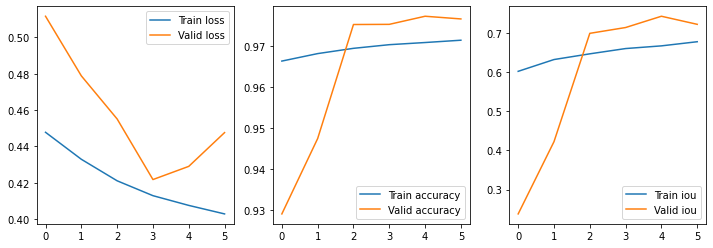

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(history.epoch, history.history["accuracy"], label="Train accuracy")
plt.plot(history.epoch, history.history["val_accuracy"], label="Valid accuracy")
plt.legend()
plt.subplot(133)
plt.plot(history.epoch, history.history["mean_iou"], label="Train iou")
plt.plot(history.epoch, history.history["val_mean_iou"], label="Valid iou")
plt.legend()
plt.show()

## Model Evalution:

In [ ]:
xmin = []
ymin = []
xmax = []
ymax = []
xmin_pred = []
ymin_pred = []
xmax_pred = []
ymax_pred = []
y_true = []
y_pred = []

In [ ]:
for imgs, msks in valid_gen:
    # predict batch of images
    preds = model.predict(imgs)
    # create figure
    # loop through batch
    for img, msk, pred in zip(imgs, msks, preds):
        # plot image
        # threshold true mask
        comp = msk[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        xmin_ = 0
        ymin_ = 0
        xmax_ = 0
        ymax_ = 0
        y_true_ = 0
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            
            y_true_ = 1
            xmin_ = x
            ymin_ = y
            xmax_ = x2
            ymax_ = y2
           
        
        # threshold predicted mask
        comp = pred[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        xmin_pred_ = 0
        ymin_pred_ = 0
        xmax_pred_ = 0
        ymax_pred_ = 0
        y_pred_ = 0
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            
            xmin_pred_ = x
            ymin_pred_ = y
            xmax_pred_ = x2
            ymax_pred_ = y2
            y_pred_ = 1
        
        y_true.append(y_true_)
        y_pred.append(y_pred_)
        
        xmin_pred.append(xmin_pred_)
        ymin_pred.append(ymin_pred_)
        xmax_pred.append(xmax_pred_)
        ymax_pred.append(ymax_pred_)
    
        xmin.append(xmin_)
        ymin.append(ymin_)
        xmax.append(xmax_)
        ymax.append(ymax_)

### Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
confusionMatrix = confusion_matrix(y_true,y_pred)
confusionMatrix

array([[1785,  228],
       [ 247,  300]])

Text(0.5, 1.0, 'Confusion Matrix)')

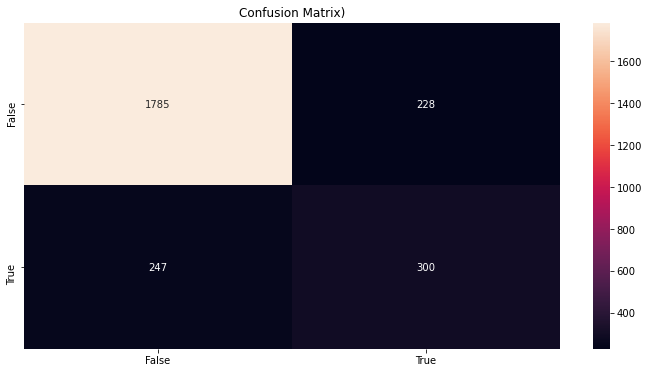

In [ ]:
df_cm = pd.DataFrame(confusionMatrix, index = [i for i in ["False","True"]], columns = [i for i in ["False","True"]])
cfFig = plt.figure(figsize = (12,6)) 
sns.heatmap(df_cm, annot=True ,fmt='g')
plt.title('Confusion Matrix)')

### Classification Report:

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=['False','True']))

              precision    recall  f1-score   support

       False       0.88      0.89      0.88      2013
        True       0.57      0.55      0.56       547

    accuracy                           0.81      2560
   macro avg       0.72      0.72      0.72      2560
weighted avg       0.81      0.81      0.81      2560



## Predict Images

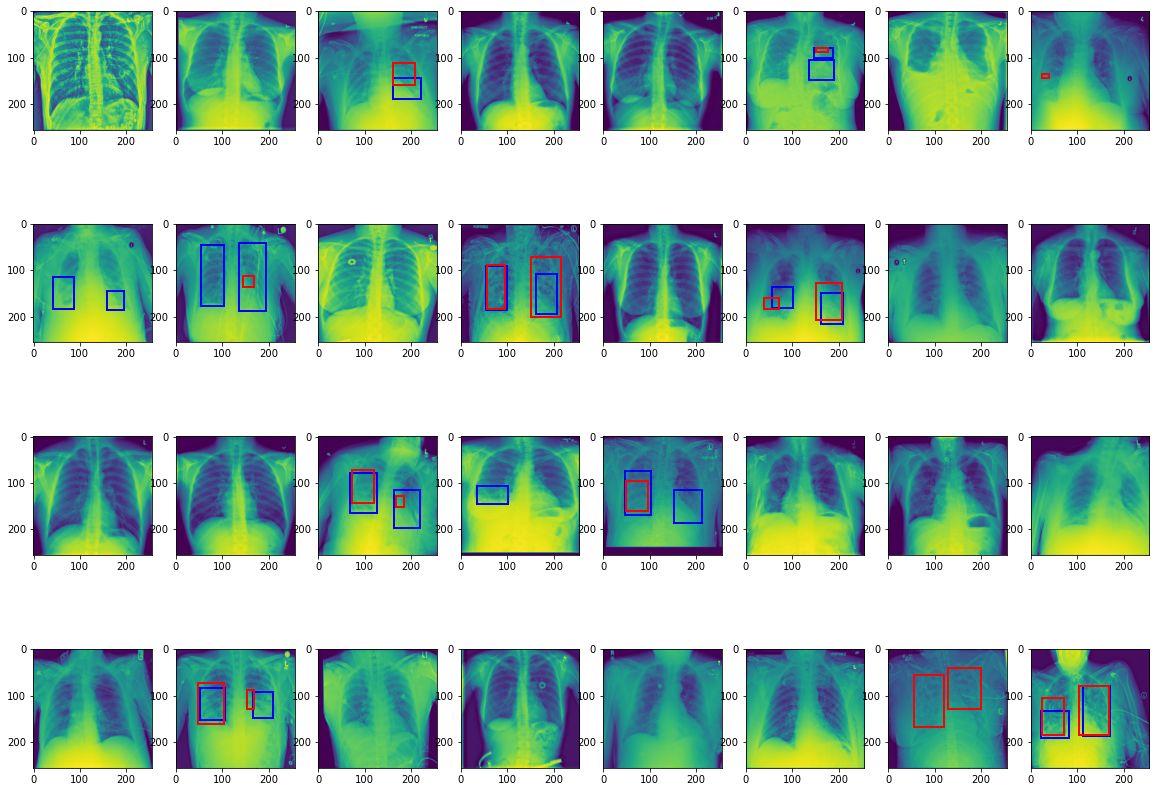

In [ ]:
for imgs, msks in valid_gen:
    # predict batch of images
    preds = model.predict(imgs)
    # create figure
    f, axarr = plt.subplots(4, 8, figsize=(20,15))
    axarr = axarr.ravel()
    axidx = 0
    # loop through batch
    for img, msk, pred in zip(imgs, msks, preds):
        # plot image
        axarr[axidx].imshow(img[:, :, 0])
        # threshold true mask
        comp = msk[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            axarr[axidx].add_patch(patches.Rectangle((x,y),width,height,linewidth=2,edgecolor='b',facecolor='none'))
        # threshold predicted mask
        comp = pred[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            axarr[axidx].add_patch(patches.Rectangle((x,y),width,height,linewidth=2,edgecolor='r',facecolor='none'))
        axidx += 1
    plt.show()
    # only plot one batch
    break

# **Summary :**

---

### Approach:

* Firstly a convolutional neural network is used to segment the image, using the bounding boxes directly as a mask. 
* Secondly connected components is used to separate multiple areas of predicted pneumonia.
* Finally a bounding box is simply drawn around every connected component.

### Network:

* The network consists of a number of residual blocks with convolutions and downsampling blocks with max pooling.
* At the end of the network a single upsampling layer converts the output to the same shape as the input.

As the input to the network is 256 by 256 (instead of the original 1024 by 1024) and the network downsamples a number of times without any meaningful upsampling (the final upsampling is just to match in 256 by 256 mask) the final prediction is very crude. If the network downsamples 4 times the final bounding boxes can only change with at least 16 pixels.

### Model Score:
We used cosine annealing learing rate function with rate of 0.001 and ran the model 6 epochs  with 32 batch size. Got the below score <br>

Loss: 0.4028 <br>
Accuracy: 0.9714<br>
Mean iou: 0.6774<br>
Validation loss: 0.4476<br>
Validation accuracy: 0.9766<br>
Validation mean iou: 0.7218<br>
Learning rate: 9.0451e-04


### Evaluation Matrics:

True Positives (TP): we correctly predicted that customer accepted the loan 300<br/>
True Negatives (TN): we correctly predicted that customer rejected the loan 1785<br/>
False Positives (FP): we incorrectly predicted that customer accepted the loan (a "Type I error") 228. Falsely predict positive is Type I error<br/>
False Negatives (FN): we incorrectly predicted that customer rejected the loan (a "Type II error") 247. Falsely predict negative is Type II error<br/>

Weighted avg precision : 0.81<br/>
Weighted avg recall : 0.81 

![alt text](https://miro.medium.com/max/1104/1*pOtBHai4jFd-ujaNXPilRg.png)


### Prediction:

We predicted the bounding boxes on validation data and implemented that over the images. As well as displayed the ground truth box with color **BLUE** and Predicted box with color **RED**.

